<a href="https://colab.research.google.com/github/Vidhii231/Basic-Chatbox-Task-3/blob/main/Text_Generation_from_Images_via_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-eng
!apt-get install -y libtesseract-dev

!pip install pytesseract opencv-python pillow matplotlib numpy
!pip install transformers torch torchvision
!pip install gtts gradio
!pip install sentence-transformers
!pip install pdf2image
print("✓ All required libraries installed successfully!")

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,081 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packag

In [2]:
import cv2
import pytesseract
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import sys
from google.colab import files
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')


In [3]:
class EnhancedImageProcessor:
    """Advanced image processing for OCR optimization"""

    def __init__(self):
        self.processed_images = {}

    def load_image(self, image_path):
        """Load image from path or URL"""
        if image_path.startswith('http'):
            import requests
            from io import BytesIO
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content))
            img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        else:
            img = cv2.imread(image_path)

        if img is None:
            raise ValueError(f"Could not load image from {image_path}")

        return img

    def preprocess_image(self, image, preprocessing_steps=['all']):
        """Apply multiple preprocessing techniques"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        processed_versions = {}

        # Method 1: Simple threshold
        _, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Method 2: Adaptive threshold
        thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)

        # Method 3: Noise removal
        denoised = cv2.medianBlur(gray, 3)
        _, thresh3 = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Method 4: Dilation and Erosion
        kernel = np.ones((2,2), np.uint8)
        dilation = cv2.dilate(thresh1, kernel, iterations=1)
        erosion = cv2.erode(dilation, kernel, iterations=1)

        # Method 5: Edge enhancement
        edges = cv2.Canny(gray, 50, 150)

        # Method 6: Contrast enhancement
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        enhanced = cv2.merge((cl, a, b))
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
        enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
        _, thresh6 = cv2.threshold(enhanced_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        processed_versions = {
            'original': image,
            'grayscale': gray,
            'simple_thresh': thresh1,
            'adaptive_thresh': thresh2,
            'denoised': thresh3,
            'morphological': erosion,
            'edges': edges,
            'contrast_enhanced': thresh6
        }

        return processed_versions

    def deskew_image(self, image):
        """Deskew text in image"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)

        coords = np.column_stack(np.where(gray > 0))
        if len(coords) == 0:
            return image

        angle = cv2.minAreaRect(coords)[-1]

        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h),
                                flags=cv2.INTER_CUBIC,
                                borderMode=cv2.BORDER_REPLICATE)

        return rotated

    def visualize_preprocessing(self, processed_images):
        """Visualize all preprocessing steps"""
        titles = list(processed_images.keys())
        images = list(processed_images.values())

        fig = plt.figure(figsize=(20, 10))
        gs = gridspec.GridSpec(2, 4)

        for i, (title, img) in enumerate(zip(titles, images)):
            ax = plt.subplot(gs[i])
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(title, fontsize=12)
            ax.axis('off')

        plt.tight_layout()
        plt.show()


In [4]:
class AdvancedOCRExtractor:
    """Extract text using multiple OCR strategies"""

    def __init__(self):
        # Configure Tesseract
        self.configs = {
            'default': r'--oem 3 --psm 6',
            'single_column': r'--oem 3 --psm 4',
            'single_line': r'--oem 3 --psm 7',
            'single_word': r'--oem 3 --psm 8',
            'sparse_text': r'--oem 3 --psm 11',
            'circle_text': r'--oem 3 --psm 12'
        }

    def extract_with_tesseract(self, image, config='default', lang='eng'):
        """Extract text using Tesseract"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        text = pytesseract.image_to_string(
            image,
            config=self.configs[config],
            lang=lang
        )

        # Get detailed data
        data = pytesseract.image_to_data(
            image,
            config=self.configs[config],
            lang=lang,
            output_type=pytesseract.Output.DICT
        )

        return text.strip(), data

    def extract_multiple_versions(self, processed_images):
        """Extract text from all processed versions"""
        results = {}

        for name, img in processed_images.items():
            try:
                if len(img.shape) == 3:  # Color image
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_pil = Image.fromarray(img_rgb)
                else:  # Grayscale image
                    img_pil = Image.fromarray(img)

                text, data = self.extract_with_tesseract(img_pil)
                confidence = np.mean([int(x) for x in data['conf'] if int(x) > 0]) if any(int(x) > 0 for x in data['conf']) else 0

                results[name] = {
                    'text': text,
                    'confidence': confidence,
                    'word_count': len(text.split())
                }

            except Exception as e:
                results[name] = {
                    'text': f"Error: {str(e)}",
                    'confidence': 0,
                    'word_count': 0
                }

        return results

    def highlight_text_regions(self, image, ocr_data):
        """Draw bounding boxes around detected text"""
        img_copy = image.copy()
        n_boxes = len(ocr_data['level'])

        for i in range(n_boxes):
            if int(ocr_data['conf'][i]) > 60:  # Only high confidence boxes
                (x, y, w, h) = (ocr_data['left'][i], ocr_data['top'][i],
                              ocr_data['width'][i], ocr_data['height'][i])
                cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
                text = ocr_data['text'][i]
                cv2.putText(img_copy, text, (x, y - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        return img_copy

    def compare_ocr_results(self, results):
        """Compare and select best OCR result"""
        best_result = None
        best_score = -1

        for name, data in results.items():
            score = data['confidence'] * 0.7 + min(data['word_count'], 100) * 0.3
            if score > best_score and data['word_count'] > 0:
                best_score = score
                best_result = data['text']

        return best_result


In [5]:
class AITextGenerator:
    """Generate text using various AI models"""

    def __init__(self):
        print("Loading AI models...")

        # Load GPT-2 for text generation
        try:
            self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
            self.gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
            self.gpt2_model.eval()
            print("✓ GPT-2 model loaded")
        except:
            print("⚠ Could not load GPT-2 model")
            self.gpt2_model = None

        # Load translation model
        try:
            self.translator = pipeline('translation_en_to_fr', model='Helsinki-NLP/opus-mt-en-fr')
            print("✓ Translation model loaded")
        except:
            print("⚠ Could not load translation model")
            self.translator = None

        # Load summarization model
        try:
            self.summarizer = pipeline('summarization', model='facebook/bart-large-cnn')
            print("✓ Summarization model loaded")
        except:
            print("⚠ Could not load summarization model")
            self.summarizer = None

        # Load text classification model
        try:
            self.classifier = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')
            print("✓ Text classification model loaded")
        except:
            print("⚠ Could not load classification model")
            self.classifier = None

    def generate_with_gpt2(self, prompt, max_length=200, temperature=0.8):
        """Generate text using GPT-2"""
        if self.gpt2_model is None:
            return "GPT-2 model not available"

        inputs = self.gpt2_tokenizer.encode(prompt, return_tensors='pt', max_length=512, truncation=True)

        with torch.no_grad():
            outputs = self.gpt2_model.generate(
                inputs,
                max_length=max_length,
                temperature=temperature,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                repetition_penalty=1.2,
                pad_token_id=self.gpt2_tokenizer.eos_token_id
            )

        generated_text = self.gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

    def summarize_text(self, text, max_length=130, min_length=30):
        """Summarize extracted text"""
        if self.summarizer is None:
            return text[:500] + "..."  # Simple truncation

        try:
            summary = self.summarizer(
                text,
                max_length=max_length,
                min_length=min_length,
                do_sample=False
            )
            return summary[0]['summary_text']
        except:
            return text[:500] + "..."

    def translate_text(self, text, target_lang='fr'):
        """Translate text to another language"""
        if self.translator is None:
            return text

        try:
            # Split text into chunks if too long
            chunks = [text[i:i+500] for i in range(0, len(text), 500)]
            translations = []

            for chunk in chunks:
                result = self.translator(chunk)[0]['translation_text']
                translations.append(result)

            return ' '.join(translations)
        except:
            return text

    def analyze_sentiment(self, text):
        """Analyze sentiment of text"""
        if self.classifier is None:
            return {"label": "NEUTRAL", "score": 0.5}

        try:
            result = self.classifier(text[:512])[0]  # Limit to first 512 chars
            return result
        except:
            return {"label": "NEUTRAL", "score": 0.5}

    def create_story(self, keywords, num_sentences=5):
        """Create a story from keywords"""
        prompt = f"Create a creative story including these keywords: {', '.join(keywords)}. Story:"
        story = self.generate_with_gpt2(prompt, max_length=300)
        return story

    def expand_text(self, text, expansion_factor=2):
        """Expand short text"""
        prompt = f"Expand and elaborate on this text: {text}\n\nExpanded version:"
        expanded = self.generate_with_gpt2(prompt, max_length=len(text.split()) * expansion_factor * 10)
        return expanded


In [15]:
class TextGeneratorPipeline:
    """Main pipeline for text generation from OCR optimized images"""

    def __init__(self):
        self.image_processor = EnhancedImageProcessor()
        self.ocr_extractor = AdvancedOCRExtractor()
        self.text_generator = AITextGenerator()

    def process_image(self, image_path, display_steps=True):
        """Process image through entire pipeline"""
        print(f"\n{'='*60}")
        print(f"PROCESSING: {image_path}")
        print(f"{'='*60}")

        # Step 1: Load and preprocess image
        print("\n1️⃣ LOADING AND PREPROCESSING IMAGE...")
        try:
            image = self.image_processor.load_image(image_path)

            if display_steps:
                plt.figure(figsize=(10, 6))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image", fontsize=16)
                plt.axis('off')
                plt.show()
        except Exception as e:
            print(f"❌ Error loading image: {str(e)}")
            return None

        # Step 2: Apply preprocessing
        print("\n2️⃣ APPLYING PREPROCESSING TECHNIQUES...")
        processed_images = self.image_processor.preprocess_image(image)

        if display_steps:
            self.image_processor.visualize_preprocessing(processed_images)

        # Step 3: Deskew if needed
        print("\n3️⃣ CHECKING FOR SKEW...")
        deskewed = self.image_processor.deskew_image(image)
        processed_images['deskewed'] = deskewed

        # Step 4: Extract text with multiple methods
        print("\n4️⃣ EXTRACTING TEXT WITH OCR...")
        ocr_results = self.ocr_extractor.extract_multiple_versions(processed_images)

        # Display OCR comparison
        print("\nOCR Results Comparison:")
        print("-"*50)
        for name, result in ocr_results.items():
            if result['word_count'] > 0:
                print(f"{name:20s} | Words: {result['word_count']:3d} | Conf: {result['confidence']:5.1f}")

        # Select best result
        best_text = self.ocr_extractor.compare_ocr_results(ocr_results)

        print("\n" + "="*50)
        print("BEST EXTRACTED TEXT:")
        print("="*50)
        if best_text:
            print(best_text[:1000])  # Show first 1000 chars
            if len(best_text) > 1000:
                print("... [truncated]")
        else:
            print("No text extracted with sufficient confidence.")
        print("="*50)

        # Step 5: Highlight text regions
        if display_steps and best_text: # Added best_text check
            print("\n5️⃣ VISUALIZING TEXT DETECTION...")
            _, ocr_data = self.ocr_extractor.extract_with_tesseract(
                Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # Pass original image for highlighting if best_text exists
            )
            highlighted = self.ocr_extractor.highlight_text_regions(image, ocr_data)

            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
            plt.title("Detected Text Regions", fontsize=16)
            plt.axis('off')
            plt.show()

        return best_text

    def generate_from_image(self, image_path, generation_type='expand'):
        """Complete pipeline from image to generated text"""
        # Extract text
        extracted_text = self.process_image(image_path, display_steps=True)

        if not extracted_text or (isinstance(extracted_text, str) and len(extracted_text.split()) < 5):
            print("⚠ Insufficient text extracted for generation")
            return extracted_text, "Please provide an image with more text." if extracted_text is None else extracted_text + " - Insufficient text for generation."

        print(f"\n{'='*60}")
        print("TEXT GENERATION PHASE")
        print(f"{'='*60}")

        generated_text = ""

        if generation_type == 'summarize':
            print("\n📝 SUMMARIZING TEXT...")
            generated_text = self.text_generator.summarize_text(extracted_text)
            print("Summary:", generated_text)

        elif generation_type == 'expand':
            print("\n✨ EXPANDING TEXT...")
            generated_text = self.text_generator.expand_text(extracted_text)
            print("Expanded:", generated_text[:500] + "..." if len(generated_text) > 500 else generated_text)

        elif generation_type == 'translate':
            print("\n🌍 TRANSLATING TO FRENCH...")
            generated_text = self.text_generator.translate_text(extracted_text)
            print("Translation:", generated_text)

        elif generation_type == 'story':
            print("\n📚 CREATING STORY FROM KEYWORDS...")
            # Extract keywords (simple approach: use capitalized words)
            words = extracted_text.split()
            keywords = [w for w in words if len(w) > 5 and w[0].isupper()][:5]
            if not keywords:
                keywords = ['technology', 'future', 'innovation', 'digital', 'transformation']

            generated_text = self.text_generator.create_story(keywords)
            print("Story:", generated_text)

        # Analyze sentiment
        print("\n😊 ANALYZING SENTIMENT...")
        sentiment = self.text_generator.analyze_sentiment(extracted_text)
        print(f"Sentiment: {sentiment['label']} (confidence: {sentiment['score']:.2f})")

        # Statistics
        print("\n📊 STATISTICS:")
        print(f"Original words: {len(extracted_text.split())}")
        print(f"Generated words: {len(generated_text.split())}")

        return extracted_text, generated_text

    def batch_process(self, image_paths):
        """Process multiple images"""
        results = {}
        for img_path in image_paths:
            print(f"\nProcessing {img_path}...")
            try:
                extracted, generated = self.generate_from_image(img_path)
                results[img_path] = {
                    'extracted': extracted,
                    'generated': generated
                }
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                results[img_path] = None
        return results

In [17]:
class TextToSpeechConverter:
    """Convert generated text to speech"""

    def __init__(self):
        from gtts import gTTS
        import IPython.display as ipd
        self.gTTS = gTTS
        self.ipd = ipd

    def text_to_speech(self, text, lang='en', filename='output.mp3'):
        """Convert text to speech and play"""
        if not text:
            print("⚠ No text provided for text-to-speech conversion.")
            return None
        try:
            tts = self.gTTS(text=text[:500], lang=lang, slow=False)  # Limit to 500 chars
            tts.save(filename)
            print(f"✓ Audio saved as {filename}")

            # Play audio in Colab
            return self.ipd.Audio(filename, autoplay=True)
        except Exception as e:
            print(f"❌ Error in text-to-speech: {str(e)}")
            return None

    def save_to_file(self, extracted_text, generated_text, filename='output.txt'):
        """Save results to text file"""
        extracted_text_str = extracted_text if extracted_text is not None else "No text extracted."
        generated_text_str = generated_text if generated_text is not None else "No text generated."

        with open(filename, 'w', encoding='utf-8') as f:
            f.write("="*60 + "\n")
            f.write("EXTRACTED TEXT\n")
            f.write("="*60 + "\n")
            f.write(extracted_text_str + "\n\n")
            f.write("="*60 + "\n")
            f.write("GENERATED TEXT\n")
            f.write("="*60 + "\n")
            f.write(generated_text_str + "\n")
        print(f"✓ Results saved to {filename}")

In [9]:
def create_sample_images():
    """Create sample images for testing"""
    print("Creating sample images...")

    # Sample 1: Technology text
    img1 = Image.new('RGB', (800, 400), color='white')
    d1 = ImageDraw.Draw(img1)

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 24)
    except:
        font = ImageFont.load_default()

    text1 = """ARTIFICIAL INTELLIGENCE REVOLUTION

Artificial Intelligence and Machine Learning are transforming
industries across the globe. Deep learning algorithms can now
recognize patterns, understand natural language, and make
predictions with unprecedented accuracy.

Key Applications:
• Healthcare: Disease diagnosis and drug discovery
• Finance: Fraud detection and algorithmic trading
• Education: Personalized learning and automated grading
• Transportation: Self-driving cars and traffic optimization

The future promises even more integration of AI into daily life."""

    d1.text((30, 30), text1, fill='black', font=font)
    img1.save("sample_tech.png")

    # Sample 2: Inspirational quote
    img2 = Image.new('RGB', (600, 300), color='lightblue')
    d2 = ImageDraw.Draw(img2)

    text2 = """INSPIRATION CORNER

"The only way to do great work is to love
what you do." - Steve Jobs

"Innovation distinguishes between a leader
and a follower." - Steve Jobs

"The future belongs to those who believe
in the beauty of their dreams." - Eleanor Roosevelt"""

    d2.text((50, 50), text2, fill='darkblue', font=font)
    img2.save("sample_quote.png")

    # Sample 3: News article snippet
    img3 = Image.new('RGB', (700, 500), color='white')
    d3 = ImageDraw.Draw(img3)

    text3 = """BREAKING NEWS: TECH ADVANCEMENT

Researchers at leading universities have
developed a new quantum computing algorithm
that could revolutionize cryptography.

The breakthrough, published in Nature
Journal, demonstrates quantum supremacy
in solving complex mathematical problems
previously thought impossible.

Key Findings:
• 1000x faster than classical computers
• Potential to break current encryption
• Opens new possibilities for drug discovery
• Could accelerate climate modeling

Experts predict widespread impact within
the next decade as the technology matures."""

    d3.text((40, 40), text3, fill='black', font=font)
    img3.save("sample_news.png")

    print("✓ Created 3 sample images:")
    print("  - sample_tech.png")
    print("  - sample_quote.png")
    print("  - sample_news.png")

    return ["sample_tech.png", "sample_quote.png", "sample_news.png"]


In [10]:
def create_gradio_interface():
    """Create a web interface for the text generator"""
    try:
        import gradio as gr

        # Initialize pipeline
        pipeline = TextGeneratorPipeline()
        tts = TextToSpeechConverter()

        def process_image_interface(image, generation_type):
            """Process image in Gradio interface"""
            # Save uploaded image
            if image is None:
                return "Please upload an image", "No image provided"

            # Convert PIL to OpenCV
            img_np = np.array(image)
            img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

            # Save temporary file
            temp_path = "temp_uploaded_image.png"
            cv2.imwrite(temp_path, img_cv)

            # Process image
            extracted, generated = pipeline.generate_from_image(
                temp_path,
                generation_type=generation_type
            )

            return extracted[:2000], generated[:2000]

        # Create interface
        iface = gr.Interface(
            fn=process_image_interface,
            inputs=[
                gr.Image(type="pil", label="Upload Image"),
                gr.Dropdown(
                    choices=["expand", "summarize", "translate", "story"],
                    label="Generation Type",
                    value="expand"
                )
            ],
            outputs=[
                gr.Textbox(label="Extracted Text", lines=10),
                gr.Textbox(label="Generated Text", lines=10)
            ],
            title="📷 AI Text Generator from Images",
            description="Upload an image with text to extract and generate new content",
            theme="soft"
        )

        return iface

    except ImportError:
        print("Gradio not installed. To use web interface: !pip install gradio")
        return None



In [11]:
def main_demo():
    """Main demonstration function"""
    print("🎯 TEXT GENERATOR USING IMAGE PROCESSING AND OCR")
    print("🎯 Google Colab Edition")
    print("="*70)

    # Option 1: Upload your own image
    print("\n📤 OPTION 1: UPLOAD YOUR OWN IMAGE")
    print("Upload an image file when prompted...")

    uploaded = files.upload()
    image_paths = list(uploaded.keys())

    if image_paths:
        print(f"\nUploaded files: {image_paths}")
        user_image = image_paths[0]
    else:
        print("\n📸 OPTION 2: USING SAMPLE IMAGES")
        # Create and use sample images
        sample_images = create_sample_images()
        user_image = sample_images[0]

    # Initialize pipeline
    print("\n🚀 INITIALIZING PIPELINE...")
    pipeline = TextGeneratorPipeline()
    tts = TextToSpeechConverter()

    # Process the image
    print(f"\n🔍 PROCESSING: {user_image}")

    # Let user choose generation type
    print("\n🎨 CHOOSE GENERATION TYPE:")
    print("1. Expand text")
    print("2. Summarize text")
    print("3. Translate to French")
    print("4. Create story")

    choice = input("\nEnter choice (1-4, default=1): ").strip()

    gen_type = 'expand'
    if choice == '2':
        gen_type = 'summarize'
    elif choice == '3':
        gen_type = 'translate'
    elif choice == '4':
        gen_type = 'story'

    # Run pipeline
    extracted, generated = pipeline.generate_from_image(
        user_image,
        generation_type=gen_type
    )

    # Text-to-speech
    print("\n🔊 TEXT-TO-SPEECH CONVERSION")
    audio = tts.text_to_speech(generated[:300])  # First 300 chars for audio

    # Save results
    tts.save_to_file(extracted, generated)

    # Download results
    files.download('output.txt')

    # Show Gradio interface option
    print("\n🌐 WEB INTERFACE OPTION")
    print("To launch a web interface, run: create_gradio_interface().launch()")

    return extracted, generated, audio

In [12]:
def quick_test():
    """Quick test without uploads"""
    print("🧪 RUNNING QUICK TEST...")

    # Create sample image
    create_sample_images()

    # Initialize
    pipeline = TextGeneratorPipeline()

    # Test with sample
    extracted, generated = pipeline.generate_from_image(
        "sample_tech.png",
        generation_type="expand"
    )

    print("\n✅ TEST COMPLETED SUCCESSFULLY!")
    return extracted, generated



Choose an option to run:
1. Run complete demo (will prompt for upload)
2. Quick test with sample images
3. Launch Gradio web interface

Enter choice (1-3, default=2): 
🧪 RUNNING QUICK TEST...
Creating sample images...
✓ Created 3 sample images:
  - sample_tech.png
  - sample_quote.png
  - sample_news.png
Loading AI models...
⚠ Could not load GPT-2 model
⚠ Could not load translation model
⚠ Could not load summarization model
⚠ Could not load classification model

PROCESSING: sample_tech.png

1️⃣ LOADING AND PREPROCESSING IMAGE...


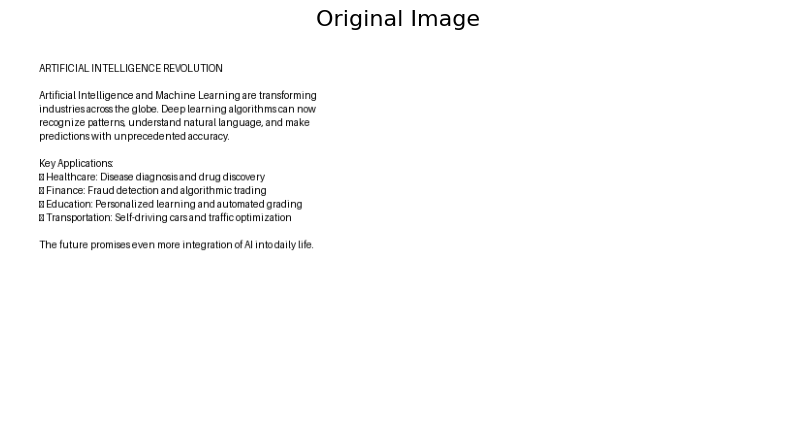


2️⃣ APPLYING PREPROCESSING TECHNIQUES...


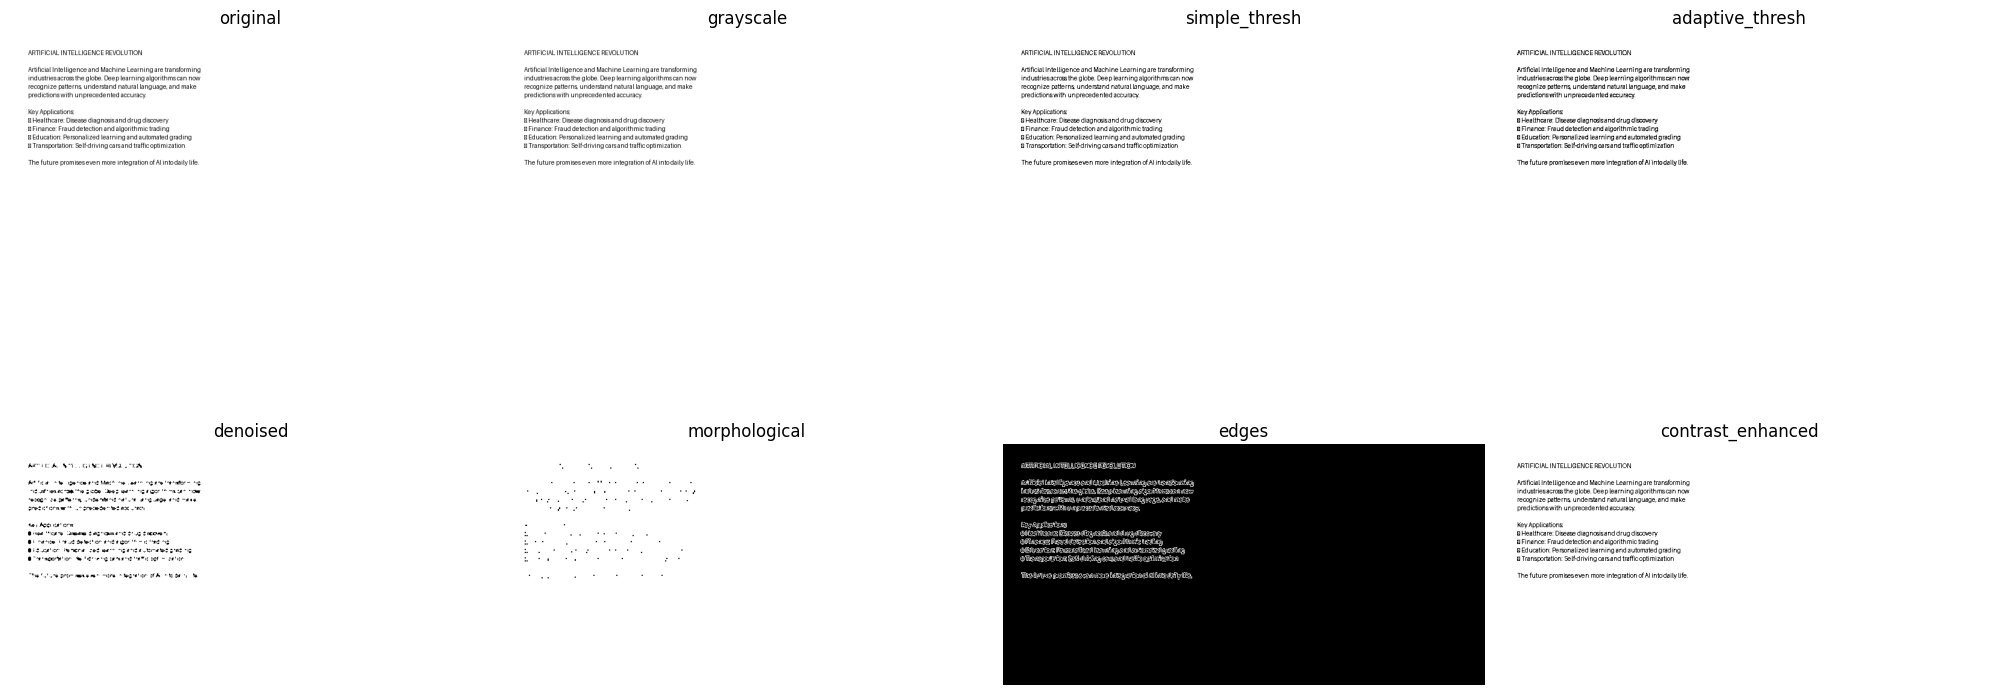


3️⃣ CHECKING FOR SKEW...

4️⃣ EXTRACTING TEXT WITH OCR...

OCR Results Comparison:
--------------------------------------------------

BEST EXTRACTED TEXT:
No text extracted with sufficient confidence.
⚠ Insufficient text extracted for generation

✅ TEST COMPLETED SUCCESSFULLY!

🎉 PROCESS COMPLETE! 🎉

Next steps:
1. Upload your own images and run the pipeline
2. Try different generation types
3. Use the web interface for easier interaction
4. Modify parameters in the code for custom behavior


In [18]:
print("\nChoose an option to run:")
print("1. Run complete demo (will prompt for upload)")
print("2. Quick test with sample images")
print("3. Launch Gradio web interface")

choice = input("\nEnter choice (1-3, default=2): ").strip() or "2"

if choice == "1":
    # Run main demo
    extracted, generated, audio = main_demo()

elif choice == "2":
    # Quick test
    extracted, generated = quick_test()

elif choice == "3":
    # Launch Gradio interface
    interface = create_gradio_interface()
    if interface:
        interface.launch(share=True)
    else:
        print("Could not create interface. Running quick test instead...")
        extracted, generated = quick_test()

else:
    print("Invalid choice. Running quick test...")
    extracted, generated = quick_test()

print("\n" + "="*70)
print("🎉 PROCESS COMPLETE! 🎉")
print("="*70)
print("\nNext steps:")
print("1. Upload your own images and run the pipeline")
print("2. Try different generation types")
print("3. Use the web interface for easier interaction")
print("4. Modify parameters in the code for custom behavior")